In [1]:
import random
from sklearn import datasets
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from dataset import MyDataset
from network import NetworkF, NetworkC

In [2]:
rnd = random.randint(1, 100000)
# rnd = 89110
random.seed(rnd)
np.random.seed(rnd)
torch.manual_seed(rnd)
torch.cuda.manual_seed(rnd)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

use_cuda = torch.cuda.is_available()
num_device = 0

device = torch.device("cuda:{}".format(num_device) if use_cuda else "cpu")
torch.cuda.set_device(num_device)


In [3]:
Xs = np.load('X_s.npy')
ys = np.load('y_s.npy')
Xt = np.load('X_t.npy')
yt = np.load('y_t.npy')

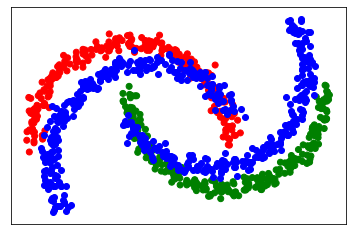

In [4]:
plt.scatter(Xs[:,0], Xs[:,1], c=ys, cmap=matplotlib.colors.ListedColormap(['red','green']))
plt.scatter(Xt[:,0], Xt[:,1], c='blue')

ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.grid(True)

In [5]:
dataset = {'S': MyDataset(Xs,ys), 'T': MyDataset(Xt,yt)}
dataloader = {x: DataLoader(dataset=dataset[x], batch_size=128, shuffle=True, num_workers=4) for x in ['S', 'T']}

num_epochs = 500
num_alpha = 0.5
line_width = 1.0
num_print = 50

In [6]:
xmin, xmax = Xs[:,0].min()-0.1, Xs[:,0].max()+0.1
ymin, ymax = Xs[:,1].min()-0.5, Xs[:,1].max()+0.5
XX, YY = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
ZZ = np.c_[XX.ravel(), YY.ravel()]
ZZ = torch.tensor(ZZ).to(device)
ZZ = ZZ.float()
ZZ.shape

torch.Size([10000, 2])

In [7]:
netF = NetworkF().to(device)
netC = NetworkC().to(device)

op_f = optim.Adam(netF.parameters(), lr=2e-4, weight_decay=5e-4)
op_c = optim.Adam(netC.parameters(), lr=2e-4, weight_decay=5e-4)

criterion = nn.CrossEntropyLoss().to(device)
  
def UncertaintyLoss(std):
    return torch.norm(std, dim=1).mean(0)


In [8]:
path_F = 'model/muda_toy_src_only_F.pth'
path_C = 'model/muda_toy_src_only_C.pth'

adapted_F = 'model/muda_toy_adapted_F_{}.pth'.format(rnd)
adapted_C = 'model/muda_toy_adapted_C_{}.pth'.format(rnd)

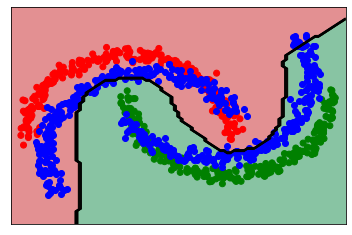

In [9]:
netF.load_state_dict(torch.load(path_F, map_location=lambda storage, loc: storage))
netC.load_state_dict(torch.load(path_C, map_location=lambda storage, loc: storage))

with torch.no_grad():
    netF.eval()
    netC.eval()

    output = F.softmax(netC(netF(ZZ, dropout=False), dropout=False),dim=1)
    ZZ_pred = output.max(1, keepdim=True)[1].cpu()

    plt.contourf(XX, YY, np.reshape(ZZ_pred.detach().numpy(), XX.shape), cmap=plt.cm.RdYlGn, alpha=num_alpha)
    plt.contour(XX, YY, np.reshape(ZZ_pred.detach().numpy(), XX.shape), linewidths=line_width, colors='k')
    plt.scatter(Xs[:,0], Xs[:,1], c=ys, cmap=matplotlib.colors.ListedColormap(['red','green']))
    plt.scatter(Xt[:,0], Xt[:,1], c='blue')

    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.grid(True)

In [10]:
T = 50
netF.load_state_dict(torch.load(path_F, map_location=lambda storage, loc: storage))
netC.load_state_dict(torch.load(path_C, map_location=lambda storage, loc: storage))
netF.train()
netC.train()

for epoch in range(num_epochs):
    for source, target in zip(dataloader['S'],dataloader['T']):
        data_s, label_s = source
        data_t, label_t = target # label_t is not used
        data_s, label_s = data_s.to(device), label_s.to(device)
        data_t = data_t.to(device)

        op_f.zero_grad()
        op_c.zero_grad()
        
        ft_s = netF(data_s)
        out_s = netC(ft_s)
        
        pred_t = []
        ft_t = netF(data_t)
        for _ in range(T):
            pred_t.append(torch.unsqueeze(F.softmax(netC(ft_t), 1), 0))

        std_t = torch.cat(pred_t, 0).std(0)
        
        loss_u = UncertaintyLoss(std_t)
        loss_s = criterion(out_s, label_s)

        loss_s.backward(retain_graph=True)
        op_c.step()

        loss = loss_s + loss_u
        loss.backward()
        op_f.step()
            
    if (epoch + 1) % num_print == 0:
        print('[epoch {:03d}/{:03d}] loss_s={:.6f}, loss_u={:.6f}'.format(
            epoch+1, num_epochs, loss_s.item(), loss_u.item()))

torch.save(netF.state_dict(), adapted_F)
torch.save(netC.state_dict(), adapted_C)


[epoch 050/500] loss_s=0.004736, loss_u=0.033604
[epoch 100/500] loss_s=0.002621, loss_u=0.045600
[epoch 150/500] loss_s=0.009252, loss_u=0.031553
[epoch 200/500] loss_s=0.005503, loss_u=0.033939
[epoch 250/500] loss_s=0.009425, loss_u=0.032936
[epoch 300/500] loss_s=0.006100, loss_u=0.035104
[epoch 350/500] loss_s=0.001722, loss_u=0.032433
[epoch 400/500] loss_s=0.007805, loss_u=0.030875
[epoch 450/500] loss_s=0.008155, loss_u=0.034482
[epoch 500/500] loss_s=0.000368, loss_u=0.025611


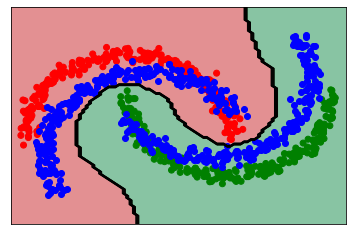

In [11]:
netF.load_state_dict(torch.load(adapted_F, map_location=lambda storage, loc: storage))
netC.load_state_dict(torch.load(adapted_C, map_location=lambda storage, loc: storage))

with torch.no_grad():
    netF.eval()
    netC.eval()

    output = F.softmax(netC(netF(ZZ, dropout=False), dropout=False),dim=1)
    ZZ_pred = output.max(1, keepdim=True)[1].cpu()

    plt.contourf(XX, YY, np.reshape(ZZ_pred.detach().numpy(), XX.shape), cmap=plt.cm.RdYlGn, alpha=num_alpha)
    plt.contour(XX, YY, np.reshape(ZZ_pred.detach().numpy(), XX.shape), linewidths=line_width, colors='k')
    plt.scatter(Xs[:,0], Xs[:,1], c=ys, cmap=matplotlib.colors.ListedColormap(['red','green']))
    plt.scatter(Xt[:,0], Xt[:,1], c='blue')

    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.grid(True)    